In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import pdb
import math

import os, sys
import pickle
import numpy as np
import torch
print("Done")


Done


In [3]:
'''
> 496.85625pt.
l.199 \showthe\textwidth
'''

width = 496.85625/2 # for half column in CVPR LaTeX templates

def set_size(width, fraction=1.0, ratio=None):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27
    
    if ratio:
        fig_width_in = fig_width_pt * inches_per_pt
        fig_height_in = fig_width_in * ratio
    else: # calculate height per golden ratio
        # Golden ratio to set aesthetic figure height
        # https://disq.us/p/2940ij3
        golden_ratio = (5**.5 - 1) / 2

        # Figure width in inches
        fig_width_in = fig_width_pt * inches_per_pt
        # Figure height in inches
        fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

dress: stage I avg ranking 28.737367630004883
dress: stage II avg ranking 22.246768951416016
dress: ranking brings forward by 6.490598678588867


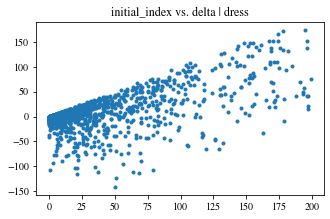

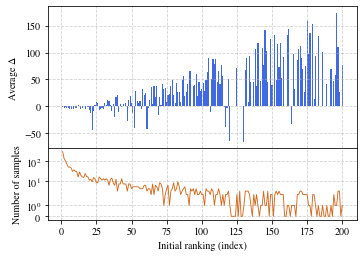

shirt: stage I avg ranking 26.959524154663086
shirt: stage II avg ranking 20.415475845336914
shirt: ranking brings forward by 6.544048309326172


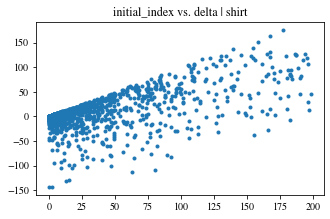

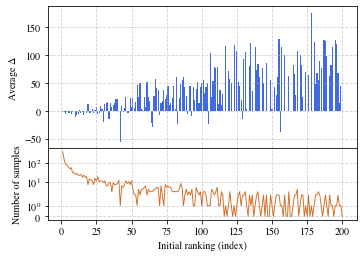

toptee: stage I avg ranking 25.808313369750977
toptee: stage II avg ranking 18.735565185546875
toptee: ranking brings forward by 7.072748184204102


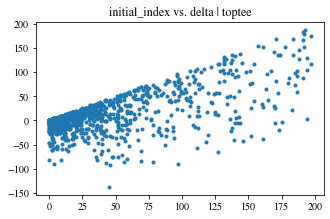

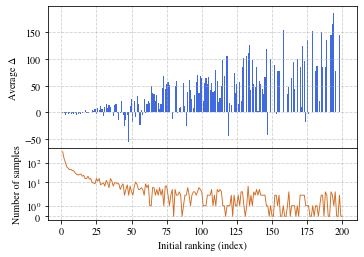

In [4]:
# Fashion IQ
K = 200
for DTYPE in ['dress', 'shirt', 'toptee']:
  _ranking_I = torch.load(f"fiq_top_200_val_{DTYPE}.pt")['labels'].nonzero()
  _ranking_II = torch.load(f"fiq_stageII_labels_val_{DTYPE}.pt").nonzero()
  _delta_ranking = _ranking_I[:,1] - _ranking_II[:,1]
  # tensor([[   0,    2],
  #         [   1,    0],
  #         [   3,    0],
  #         ...,
  #         [2014,    9],
  #         [2015,    6],
  #         [2016,   86]])
  # (Pdb) dress_labels.nonzero().shape
  # torch.Size([1702, 2])

  #NOTE: count for every initial index, the average delta it brings forward
  deltas = []; counts = []
  for i in range(K):
        _mask_i = _ranking_I[:,1] == i # mask of rows where init_ranking == i
        _rerank_of = _ranking_II[_mask_i][:,1] # re-rankings of these rows
        _delta_of = i - _rerank_of.sum() / _rerank_of.shape[0] # the delta
        deltas.append(_delta_of.item())
        counts.append(_mask_i.sum().item())
  deltas = [0.0 if math.isnan(ii) else ii for ii in deltas]
  
  print('=======')
  print(f"{DTYPE}: stage I avg ranking {_ranking_I[:,1].sum() / _ranking_I.shape[0]}")
  print(f"{DTYPE}: stage II avg ranking {_ranking_II[:,1].sum() / _ranking_II.shape[0]}")
  print(f"{DTYPE}: ranking brings forward by {_ranking_I[:,1].sum() / _ranking_I.shape[0] - _ranking_II[:,1].sum() / _ranking_II.shape[0]}")

  # initial_index vs. delta
  plt.figure()
  fig =plt.gcf()
  fig.set_size_inches(set_size(width, fraction=1.5))
  fig.tight_layout()
  plt.scatter(_ranking_I[:,1], _delta_ranking, marker=".")
  plt.title(f"initial_index vs. delta | {DTYPE}")
  plt.show()
  plt.close()

#   fig, ax1 = plt.subplots()
#   fig =plt.gcf()
#   fig.set_size_inches(set_size(width, fraction=1.5))
#   fig.tight_layout()
#   color = 'k'
#   ax1.set_xlabel('Initial ranking (index)')
#   ax1.set_ylabel('Average $\Delta$', color=color)
#   ax1.bar(x=list(range(K)), height=deltas, align='center', color='royalblue')
#   ax1.tick_params(axis='y', labelcolor=color)

#   ax2 = ax1.twinx()
#   ax2.set_ylabel('Count', color=color)  # we already handled the x-label with ax1
#   ax2.plot(list(range(K)), counts, 'chocolate', linewidth=0.9, alpha=0.6, linestyle='-')
#   ax2.tick_params(axis='y', labelcolor=color)
#   ax2.set_yscale('log')
#   ax2.grid(None)

#   plt.title(f"init_index vs. delta avg | {DTYPE}")
#   save_path = "cache/analysis_target_ranking/figures/" + f"fiq_init_index_vs_delta_avg_{DTYPE}" + '.pdf'
#   plt.savefig(save_path, format='pdf',bbox_inches='tight')
#   plt.show()
#   plt.close()
  
  fig = plt.figure()
  # set height ratios for subplots
  gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
  
  
  color = 'k'
  # Plot each graph, and manually set the y tick values
  
  ax1 = plt.subplot(gs[0])
  ax1.set_ylabel('Average $\Delta$', color=color)
  ax1.bar(x=list(range(1,K+1)), height=deltas, width=0.8, align='center', color='royalblue')
  ax1.tick_params(axis='y', labelcolor=color)
  # ax1.set_yticks(np.arange(-150, 10, 200))
  ax1.grid(True, linestyle='--', alpha=0.6)
  
  ax2 = plt.subplot(gs[1], sharex = ax1)
  ax2.set_xlabel('Initial ranking (index)')
  ax2.set_ylabel('Number of samples', color=color)  # we already handled the x-label with ax1
  ax2.plot(list(range(1,K+1)), counts, 'chocolate', linewidth=0.9)
  ax2.set_yscale('symlog')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.grid(True, linestyle='--', alpha=0.6)
  
  fig =plt.gcf()
  fig.set_size_inches(set_size(width, fraction=1.5, ratio = 1/1.4))
  fig.tight_layout()
  
  plt.subplots_adjust(hspace=.0)
  # plt.title(f"{DTYPE} init_index vs. delta avg")
  # save_path = "./figures/" + f"fiq_init_index_vs_delta_avg_{DTYPE}" + '.pdf'
  # plt.savefig(save_path, format='pdf',bbox_inches='tight')
  plt.show()
  plt.close()

All: stage I avg ranking 5.315776824951172
All: stage II avg ranking 4.094275951385498
All: ranking brings forward by 1.2215008735656738


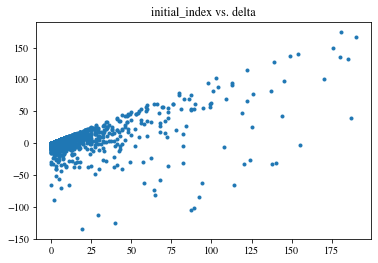

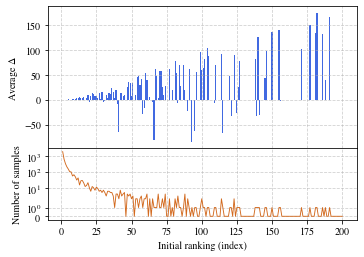

In [5]:
# CIRR
K = 200
DTYPE = 'All'
_ranking_I = torch.load(f"cirr_top_200_val.pt")['labels'].nonzero()
_ranking_II = torch.load(f"cirr_stageII_labels_val.pt").nonzero()
_delta_ranking = _ranking_I[:,1] - _ranking_II[:,1]
# tensor([[   0,    2],
#         [   1,    0],
#         [   3,    0],
#         ...,
#         [2014,    9],
#         [2015,    6],
#         [2016,   86]])
# (Pdb) dress_labels.nonzero().shape
# torch.Size([1702, 2])

#NOTE: count for every initial index, the average delta it brings forward
deltas = []; counts = []
for i in range(K):
      _mask_i = _ranking_I[:,1] == i # mask of rows where init_ranking == i
      _rerank_of = _ranking_II[_mask_i][:,1] # re-rankings of these rows
      _delta_of = i - _rerank_of.sum() / _rerank_of.shape[0] # the delta
      deltas.append(_delta_of.item())
      counts.append(_mask_i.sum().item())
deltas = [0.0 if math.isnan(ii) else ii for ii in deltas]

print('=======')
print(f"{DTYPE}: stage I avg ranking {_ranking_I[:,1].sum() / _ranking_I.shape[0]}")
print(f"{DTYPE}: stage II avg ranking {_ranking_II[:,1].sum() / _ranking_II.shape[0]}")
print(f"{DTYPE}: ranking brings forward by {_ranking_I[:,1].sum() / _ranking_I.shape[0] - _ranking_II[:,1].sum() / _ranking_II.shape[0]}")

# initial_index vs. delta
plt.figure()
plt.scatter(_ranking_I[:,1], _delta_ranking, marker=".")
plt.title(f"initial_index vs. delta")
plt.show()
plt.close()

# fig, ax1 = plt.subplots()
# fig =plt.gcf()
# fig.set_size_inches(set_size(width, fraction=1.5))
# fig.tight_layout()
# color = 'k'
# ax1.set_xlabel('Initial ranking (index)')
# ax1.set_ylabel('Average $\Delta$', color=color)
# ax1.bar(x=list(range(K)), height=deltas, width=0.8, align='center', color='royalblue')
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# ax2.set_ylabel('Count', color=color)  # we already handled the x-label with ax1
# ax2.plot(list(range(K)), counts, 'chocolate', linewidth=0.9, alpha=0.6)
# ax2.set_yscale('symlog')
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.grid(None)

# plt.title(f"init_index vs. delta avg")
# save_path = "cache/analysis_target_ranking/figures/" + f"cirr_init_index_vs_delta_avg" + '.pdf'
# plt.savefig(save_path, format='pdf',bbox_inches='tight')
# plt.show()
# plt.close()

fig = plt.figure()
# set height ratios for subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 


color = 'k'
# Plot each graph, and manually set the y tick values

ax1 = plt.subplot(gs[0])
ax1.set_ylabel('Average $\Delta$', color=color)
ax1.bar(x=list(range(1,K+1)), height=deltas, width=0.8, align='center', color='royalblue')
ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_yticks(np.arange(-150, 10, 200))
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = plt.subplot(gs[1], sharex = ax1)
ax2.set_xlabel('Initial ranking (index)')
ax2.set_ylabel('Number of samples', color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,K+1)), counts, 'chocolate', linewidth=0.9)
ax2.set_yscale('symlog')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(True, linestyle='--', alpha=0.6)

fig =plt.gcf()
fig.set_size_inches(set_size(width, fraction=1.5, ratio = 1/1.4))
fig.tight_layout()

plt.subplots_adjust(hspace=.0)
# plt.title(f"init_index vs. delta avg")
# save_path = "./figures/" + f"cirr_init_index_vs_delta_avg" + '.pdf'
# plt.savefig(save_path, format='pdf',bbox_inches='tight')
plt.show()
plt.close()